In [1]:
import matplotlib.pyplot as plt

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]


In [3]:
import numpy as np

In [4]:
import pathlib

In [5]:
import best

In [6]:
import sympy as sp

In [7]:
from scipy import optimize

In [8]:
class SemiAnalytical():
    def __init__(self, ells, MandelRep, Bvec):
                
        
        self.E = np.ones(6)
        self.P = self.getP()
        self.Q = self.getQ()
        
        self.M = MandelRep
        self.invM = np.linalg.inv(MandelRep)
        self.Bvec = Bvec
        
        self.K = self.P+np.sqrt(2)*self.Q
        
        self.ells = ells
        
        self.C = np.einsum('i, ij -> j', self.E.T, self.K)
        
        self._create_stuff()
        
            
    def getP(self):
        P = np.zeros((6, 6))
        P[0, 0] = 1
        P[1, 1] = 1
        P[2, 2] = 1
        return P
    
    def getQ(self):
        Q = np.zeros((6, 6))
        Q[3, 3] = 1
        Q[4, 4] = 1
        Q[5, 5] = 1
        return Q
    
    
    def integrate(self, y, ells):
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor
        
    def _create_stuff(self):
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P6 = np.zeros((6, 6))
        P6[0, 5] = 1

        Q = 2*P1.T@P2
        self.Z1 = Q-P6.T@P6
        self.Q1 = Q
        
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P5 = np.zeros((6, 6))
        P5[0, 4] = 1

        Q = 2*P1.T@P3
        self.Z2 = Q-P5.T@P5
        self.Q2 = Q
        
        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P4 = np.zeros((6, 6))
        P4[0, 3] = 1

        Q = 2*P2.T@P3
        self.Z3 = Q-P4.T@P4
        self.Q3 = Q
        
    def _get_useful_matrices(self):
        Z1, Z2, Z3 = self.Z1, self.Z2, self.Z3
        
        invMandel = self.invM
        K = self.K
        C = self.C
        E = self.E
        
        Bvec = self.Bvec
        
        ells = self.ells
        
        return ells, Bvec, invMandel, Z1, Z2, Z3, K, C, E
    
    
    def getMVA():

        number = np.einsum('ij, ...jk, k, i', self.K, self.invM, self.C, self.E)
        Norm = self.integrate(number, self.ells)

        O = np.einsum('ij, ...jk, ...k, i', self.K, self.invM, self.Bvec, self.E)
        O = self.integrate(O, self.ells)

        A0 = MM@C/Norm
 
        return A0

    def gettotalfunctional(A0, FB):
        total = 0
        variance = np.einsum('...i, ...ik, ...k -> ...', A0, self.M, A0)
        variance = self.integrate(number, self.ells)
        bias = np.einsum('...i, ...i -> ...', A0, self.Bvec)
        bias = self.integrate(bias, self.ells)
        total = variance+FB*bias**2.
        return total
        
    def A0getter(self, FB):
        def getA0(x):
            
            newx = x.reshape((len(self.ells), 3))
            l1, l2, l3 = newx[:, 0], newx[:, 1], newx[:, 2]

            part = np.einsum('..., ...ij, jk -> ...ik', l1, self.invM, self.Z1)
            part += np.einsum('..., ...ij, jk -> ...ik', l2, self.invM, self.Z2)
            part += np.einsum('..., ...ij, jk -> ...ik', l3, self.invM, self.Z3)

            identity = np.diag(np.ones(6, dtype = float))
            R = identity+part

            invR = np.linalg.inv(R)

            MM = np.einsum('...ij, ...jk -> ...ik', invR, self.invM)

            number = np.einsum('ij, ...jk, k, i -> ...', self.K, MM, self.C, self.E)
            Norm = self.integrate(number, self.ells)

            O = np.einsum('ij, ...jk, ...k, i -> ...', self.K, MM, self.Bvec, self.E)
            O = self.integrate(O, self.ells)

            Ofactor = np.einsum('...ij, j, ...i -> ...', MM, self.C, self.Bvec)
            Ofactor = self.integrate(Ofactor, self.ells)

            Bfactor = np.einsum('...ij, ...j, ...i -> ...', MM, self.Bvec, self.Bvec)
            Bfactor = self.integrate(Bfactor, self.ells)

            den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor

            num = (Ofactor/Norm)*np.einsum('...ij, ...j -> ...i', MM, (O/Norm)*self.C-self.Bvec)

            A0 = MM@self.C/Norm+FB*num/den

            return A0
        return getA0
        
        
        

In [13]:
Tlabel = 'T'
Slabel = 'S'
Plabel = 'P'

In [14]:
cases = [Tlabel, Plabel, Slabel]

In [15]:
colors = {}
colors[Tlabel] = 'green'
colors[Plabel] = 'blue'
colors[Slabel] = 'orange'

In [16]:
p = pathlib.Path('../qelensingcomb/output/')
def getdir(l1, l2 = None, l3 = None):
    if (l2 is not None) and (l3 is not None):
        return f'h{l1}s{l2}b{l3}/tsz/'
    else:
        l = l1
        return f'h{l}s{l}b{l}/tsz/'

getT = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'T_tsz_148.npy')#[index, index]
getP = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'P_tsz_148.npy')#[index, index]
getS = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'S_tsz_148.npy')#[index, index]
getPC = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'PC_tsz_148.npy')
getells = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'ells_tsz_148.npy')
getkk = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'kk_tsz_148.npy')
getkg = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'kg_tsz_148.npy')

In [17]:
l1, l2, l3 = 2500, 4000, 4000

In [18]:
ells = getells(l1, l2, l3)

In [19]:
sel = (ells>30) & (ells<1200)

In [20]:
ells = ells[sel]

In [21]:
clkk = getkk(l1, l2, l3)[sel]

In [22]:
clkg = getkg(l1, l2, l3)[sel]

In [23]:
theta = np.load(p/getdir(l1, l2, l3)/'theta_tsz_148.npy')[..., sel]

In [24]:
theta = theta/clkk**2.
theta = np.nan_to_num(theta)

In [25]:
thetacross = np.load(p/getdir(l1, l2, l3)/'thetacross_tsz_148.npy')[..., sel]

In [26]:
thetacross = thetacross/clkg**2.
thetacross = np.nan_to_num(thetacross)

In [27]:
N = np.load(p/getdir(l1, l2, l3)/'N_tsz_148.npy')[..., sel]

In [28]:
indices_pairs = [(0, 0), (1, 1), (2, 2), (1, 2), (2, 0), (0, 1)]

In [29]:
MandelMatrix = np.ones((len(ells), 6, 6))

In [30]:
theta.shape

(3, 3, 3, 3, 8)

In [31]:
for A, pairA in enumerate(indices_pairs):
    for B, pairB in enumerate(indices_pairs):
        i, j = pairA
        m, n = pairB
        factorA = 1. if i == j else np.sqrt(2)
        factorB = 1. if m == n else np.sqrt(2)
        
        MandelMatrix[:, A, B] = factorA*factorB*theta[i, j, m, n]

In [70]:
B = (getT(l1, l2, l3)+getP(l1, l2, l3)+getS(l1, l2, l3))
B = B[..., sel]/clkk

In [71]:
BC = getPC(l1, l2, l3)[..., sel]/clkg

## Differential evolution solution

In [36]:
FB = 0.

In [37]:
Optimizerkk = best.Opt(['hu_ok', 'shear', 'bh'], 30, 1200, ells, ells*0.+1., 
                       np.nan_to_num(theta), np.nan_to_num(B), np.nan_to_num(N))

In [38]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [39]:
result_0 = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000138
Generation 100 has ChiSquare: 0.000068
Generation 200 has ChiSquare: 0.000055
Generation 300 has ChiSquare: 0.000049
Generation 400 has ChiSquare: 0.000048
Generation 500 has ChiSquare: 0.000045
Generation 600 has ChiSquare: 0.000044
Generation 700 has ChiSquare: 0.000044
Generation 800 has ChiSquare: 0.000044
Generation 900 has ChiSquare: 0.000044
Generation 1000 has ChiSquare: 0.000043
Generation 1100 has ChiSquare: 0.000043
Generation 1200 has ChiSquare: 0.000043
Generation 1300 has ChiSquare: 0.000043
Generation 1400 has ChiSquare: 0.000043
Generation 1500 has ChiSquare: 0.000043
Generation 1600 has ChiSquare: 0.000043
Generation 1700 has ChiSquare: 0.000043
Generation 1800 has ChiSquare: 0.000043
Generation 1900 has ChiSquare: 0.000043
Generation 2000 has ChiSquare: 0.000043
Generation 2100 has ChiSquare: 0.000043
Generation 2200 has ChiSquare: 0.000043
Generation 2300 has ChiSquare: 0.000043
Ge

In [40]:
FB = 1.

In [41]:
result_1 = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000783
Generation 100 has ChiSquare: 0.000460
Generation 200 has ChiSquare: 0.000307
Generation 300 has ChiSquare: 0.000277
Generation 400 has ChiSquare: 0.000277
Generation 500 has ChiSquare: 0.000238
Generation 600 has ChiSquare: 0.000196
Generation 700 has ChiSquare: 0.000193
Generation 800 has ChiSquare: 0.000189
Generation 900 has ChiSquare: 0.000185
Generation 1000 has ChiSquare: 0.000183
Generation 1100 has ChiSquare: 0.000183
Generation 1200 has ChiSquare: 0.000181
Generation 1300 has ChiSquare: 0.000180
Generation 1400 has ChiSquare: 0.000180
Generation 1500 has ChiSquare: 0.000177
Generation 1600 has ChiSquare: 0.000177
Generation 1700 has ChiSquare: 0.000177
Generation 1800 has ChiSquare: 0.000177
Generation 1900 has ChiSquare: 0.000177
Generation 2000 has ChiSquare: 0.000173
Generation 2100 has ChiSquare: 0.000173
Generation 2200 has ChiSquare: 0.000173
Generation 2300 has ChiSquare: 0.000171
Ge

## New Matrix reshaping

In [42]:
a_random = np.random.randn(3)

In [43]:
def getAmatrix(a):
    Avec = np.zeros(6)
    Avec[0] = a[0]**2
    Avec[1] = a[1]**2
    Avec[2] = a[2]**2
    Avec[3] = a[1]*a[2]*np.sqrt(2)
    Avec[4] = a[0]*a[2]*np.sqrt(2)
    Avec[5] = a[0]*a[1]*np.sqrt(2)
    return Avec

In [44]:
Avec_random = getAmatrix(a_random)

In [72]:
B[..., 0]

array([[-0.01245095, -0.01047019, -0.01535621],
       [-0.01047019, -0.01254627, -0.02016909],
       [-0.01535621, -0.02016909, -0.02661875]])

In [73]:
Avec = np.zeros((len(ells), 6))
Avec[:, 0] = B[0, 0]
Avec[:, 1] = B[1, 1]
Avec[:, 2] = B[2, 2]
Avec[:, 3] = B[1, 2]*np.sqrt(2)
Avec[:, 4] = B[0, 2]*np.sqrt(2)
Avec[:, 5] = B[0, 1]*np.sqrt(2)

In [74]:
Bvec = abs(Avec)
Bvecnonabs = Avec

In [75]:
kk = 1
MandelMatrix[kk, ...] == MandelMatrix[kk, ...].T

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [76]:
def is_pos_def(x):
    try:
        np.linalg.cholesky(x)
        return True
    except:
        return False

In [77]:
is_pos_def(MandelMatrix[kk, ...] )

True

### Create object

In [52]:
SA = SemiAnalytical(ells, MandelMatrix, Bvec)

## MV Solution part

In [201]:
#MV SOLUTION

mvnorm = SA.integrate(np.einsum('...ij, i, j -> ...', SA.invM, SA.C, SA.C), ells)
mvunnorm = np.einsum('...ij, j -> ...i', SA.invM, SA.C)

AMV = mvunnorm/mvnorm

print('Check', SA.integrate(np.einsum('...i, ...i -> ...', AMV, SA.C), ells))

bMV = SA.integrate(np.einsum('...i, ...i -> ...', AMV, SA.Bvec), ells)

#CHECK BIAS

fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = False, analytical = False)
f, n, b = fnb_getter(Optimizerkk, 0., False)

print('bias result', b(result_0.x), 'bias analytical', bMV)

Check 1.0000000000000009
bias result 0.019474312720822867 bias analytical 0.01939358524431624


In [190]:
w_from_prime = AMV[:, 0:3].sum(axis = 1)+np.sqrt(2)*AMV[:, 3:6].sum(axis = 1)
w_from_prime

array([1.24707153e-05, 1.14393266e-05, 9.34973459e-06, 6.85824518e-06,
       3.57094755e-06, 1.63340628e-06, 6.14277375e-07, 2.15018761e-07])

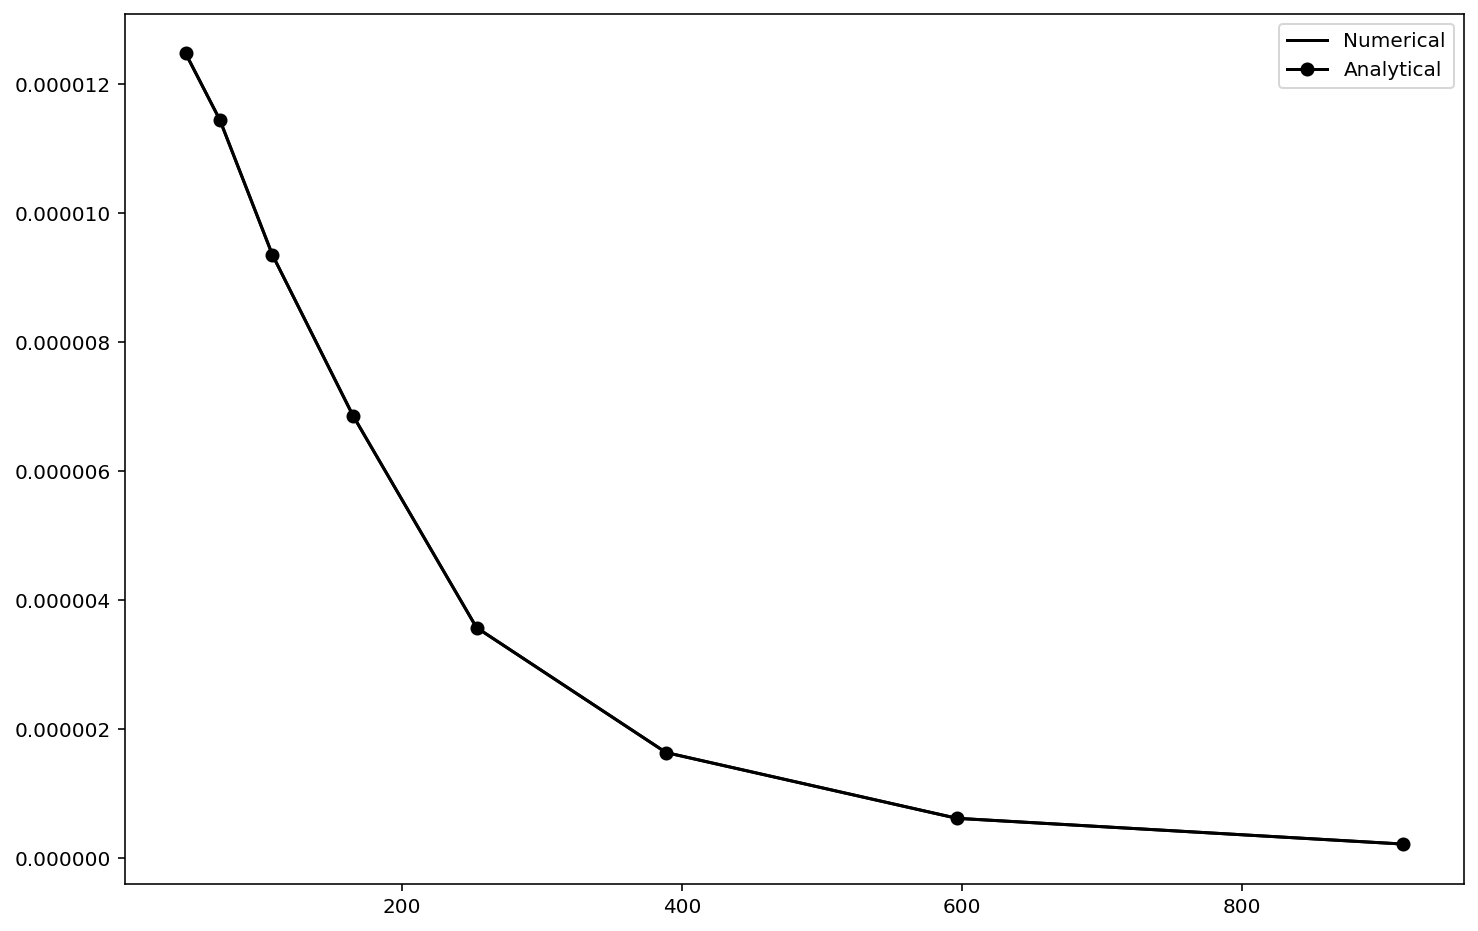

In [245]:
plt.plot(ells, result_0.ws[-1], color = 'black', label = 'Numerical')
plt.plot(ells, w_from_prime, color = 'black', marker = 'o', label = 'Analytical')
plt.legend()

In [192]:
A1prime = np.sqrt(AMV[..., 0]) 
A2prime = np.sqrt(AMV[..., 1]) 
A3prime = np.sqrt(AMV[..., 2]) 

a1 = np.nan_to_num(A1prime/np.sqrt(w_from_prime))
a2 = np.nan_to_num(A2prime/np.sqrt(w_from_prime))
a3 = np.nan_to_num(A3prime/np.sqrt(w_from_prime))
print(a1+a2+a3)
      
a1code, a2code, a3code, w = result_0.ws

[1.         1.         1.00022857 1.00122428 1.00259401 1.01161473
 1.0253882  1.0249023 ]


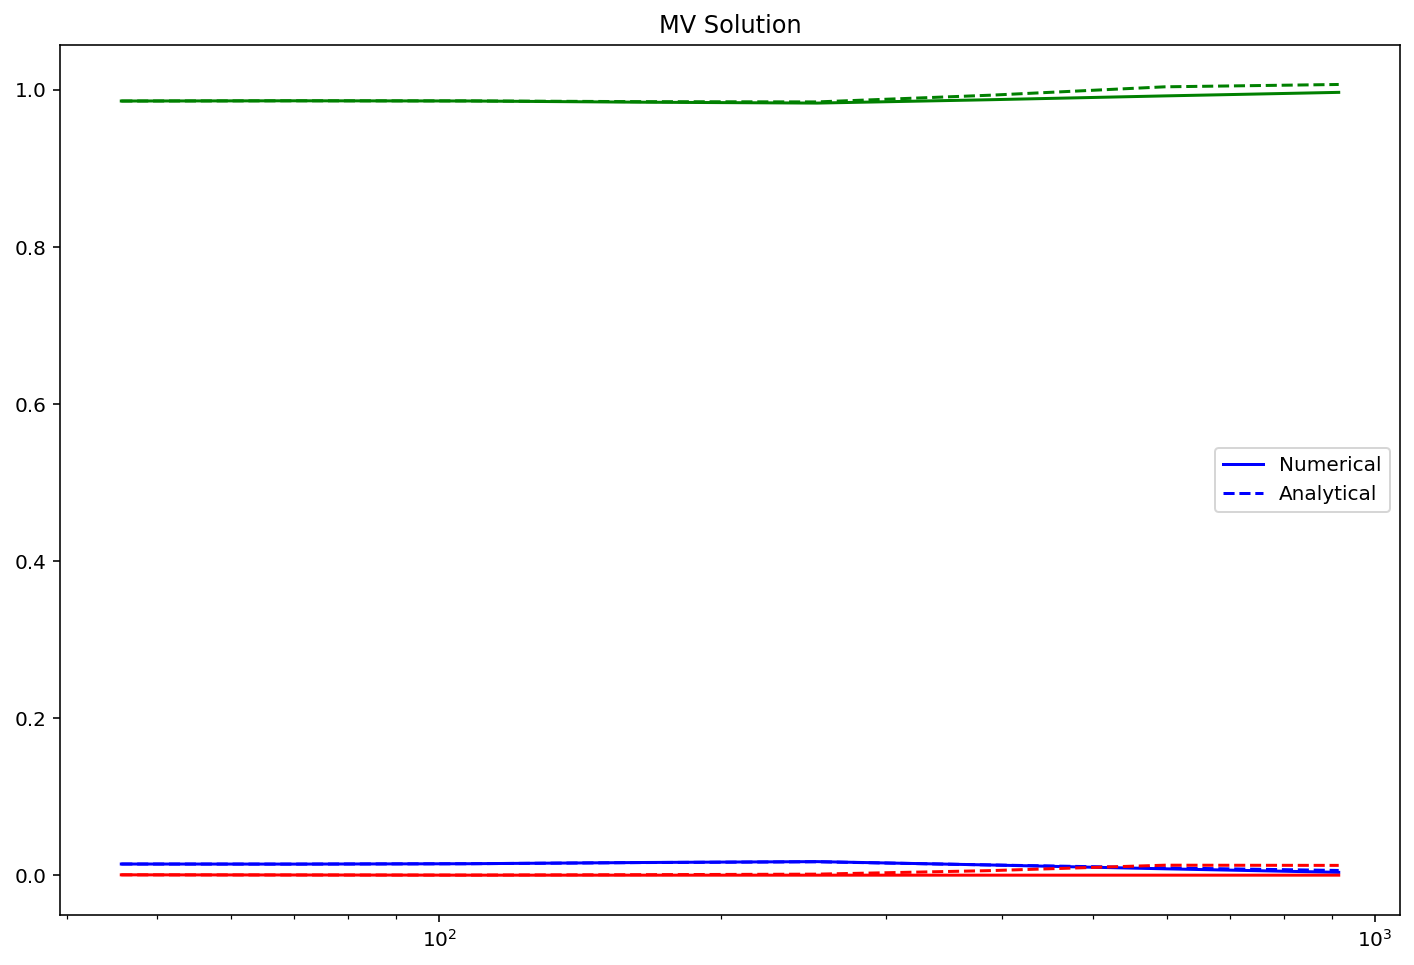

In [193]:
plt.title('MV Solution')

plt.plot(ells, a1code, color = 'blue', label = 'Numerical')
plt.plot(ells, a2code, color = 'red')
plt.plot(ells, a3code, color = 'green')

plt.plot(ells, a1, ls = '--', color = 'blue', label = 'Analytical')
plt.plot(ells, a2, ls = '--', color = 'red')
plt.plot(ells, a3, ls = '--', color = 'green')
plt.xscale('log')
plt.legend()

## Bias correction

In [222]:
def getA(SA, selectionnot):
    mvnorm = SA.integrate(np.einsum('...ij, i, ...j, j -> ...', SA.invM, SA.C, selectionnot, SA.C), ells)
    mvunnorm = np.einsum('...ij, j -> ...i', SA.invM, SA.C)

    AMV = mvunnorm/mvnorm


    X = SA.integrate(np.einsum('...ij, i, ...j, ...j -> ...', SA.invM, SA.C, selectionnot, SA.Bvec), ells)
    Y = SA.integrate(np.einsum('...ij, ...i, ...j, ...j -> ...', SA.invM, SA.Bvec, selectionnot, SA.Bvec), ells)

    fb = 1.

    bBC = bMV/(1+fb*Y-bMV*fb*X)

    print('bias result', b(result_1.x), 'bias analytical', bBC)


    ABC = AMV*(1+fb*bBC*X)-fb*bBC*np.einsum('...ij, ...j -> ...i', SA.invM, SA.Bvec)
    
    return ABC

In [242]:
2*ABC[0][0]*ABC[0][1]/ABC[0][5]**2

-1.3504406290387037

In [240]:
selection = AMV<np.inf
result__ = getA(SA, selection)

while not(np.all(result__>=0)):
    selectionnot = result__>0
    result__ = getA(SA, selectionnot)
    result__last = result__.copy()
    result__ *= selectionnot

bias result 0.008954453444576231 bias analytical 0.0007550037944039739
bias result 0.008954453444576231 bias analytical -0.00038209954737547996
bias result 0.008954453444576231 bias analytical -0.005606847666062353
bias result 0.008954453444576231 bias analytical 0.0048989302915598545


In [247]:
getA(SA, selection)>0

bias result 0.008954453444576231 bias analytical 0.0007550037944039739


array([[False,  True, False,  True,  True, False],
       [False,  True, False,  True,  True, False],
       [False,  True, False,  True,  True, False],
       [False,  True, False,  True,  True, False],
       [False,  True,  True, False,  True,  True],
       [False,  True,  True, False,  True,  True],
       [False,  True,  True, False,  True,  True],
       [False,  True,  True, False,  True,  True]])

In [227]:
result_1.ws

(array([0.77182004, 0.52000523, 0.55304556, 0.76080487, 0.90786091,
        0.68569698, 0.97390215, 0.53034359]),
 array([0.22290328, 0.44139423, 0.44258622, 0.23670919, 0.0278151 ,
        0.0015231 , 0.01767803, 0.05855679]),
 array([0.00527668, 0.03860053, 0.00436821, 0.00248594, 0.06432399,
        0.31277992, 0.00841983, 0.41109962]),
 array([1.60033650e-05, 2.90427387e-05, 1.84868397e-05, 9.20970161e-06,
        3.98870215e-06, 1.24189829e-06, 1.64032152e-07, 6.83791093e-09]))

In [53]:
number = np.einsum('ij, ...jk, k, i', SA.K, SA.invM, SA.C, SA.E)
Norm = SA.integrate(number, ells)

In [54]:
O = np.einsum('ij, ...jk, ...k, i', SA.K, SA.invM, SA.Bvec, SA.E)
O = SA.integrate(O, ells)

In [55]:
Ofactor = np.einsum('...ij, j, ...i', SA.invM, SA.C, SA.Bvec)
Ofactor = SA.integrate(Ofactor, ells)

In [56]:
Ofactornonabs = np.einsum('...ij, j, ...i', SA.invM, SA.C, Bvecnonabs)
Ofactornonabs = SA.integrate(Ofactornonabs, ells)

In [57]:
Bfactor = np.einsum('...ij, ...j, ...i -> ...', SA.invM, SA.Bvec, SA.Bvec)
Bfactor = SA.integrate(Bfactor, ells)

In [58]:
number = np.einsum('ij, ...jk, k, i', SA.K, SA.invM, SA.C, SA.E)
Norm = SA.integrate(number, ells)

In [59]:
O = np.einsum('ij, ...jk, ...k, i', SA.K, SA.invM, SA.Bvec, SA.E)
O = SA.integrate(O, ells)

In [78]:
FB = 0.

In [79]:
den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor

In [80]:
bias = Ofactor/Norm/den
bias

0.019393585244316235

In [81]:
Vec = 1/Norm*np.einsum('...ij, j -> ...i', SA.invM, SA.C)+FB*bias*np.einsum('...ij, ...j -> ...i', SA.invM, (O/Norm)*SA.C-Bvec)

In [82]:
Vec2 = 1/Norm*np.einsum('...ij, j -> ...i', SA.invM, SA.C)+FB*bias*np.einsum('...ij, ...j -> ...i', SA.invM, (O/Norm)*SA.C)

In [84]:
Vec[0]

array([2.51040510e-09, 2.25068267e-12, 1.21089093e-05, 7.38286029e-09,
       2.46569535e-07, 1.06302638e-10])

In [85]:
Vec2[0]

array([2.51040510e-09, 2.25068267e-12, 1.21089093e-05, 7.38286029e-09,
       2.46569535e-07, 1.06302638e-10])

In [86]:
Vec2[0]

array([2.51040510e-09, 2.25068267e-12, 1.21089093e-05, 7.38286029e-09,
       2.46569535e-07, 1.06302638e-10])

In [87]:
2*Vec2[0][0]*Vec2[0][1]-Vec2[0][5]**2

-2.923875296280533e-28

In [88]:
Vec2[0][5]**2

1.1300250782444963e-20

In [89]:
2*Vec2[0][0]*Vec2[0][1]

1.1300250490057434e-20

In [90]:
(np.sqrt(Vec2[:][0])+np.sqrt(Vec2[:][1])+np.sqrt(Vec2[:][2]))**2

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([2.02349451e-08, 7.01635935e-12, 9.65725114e-05,            nan,
       1.97683918e-06,            nan])

In [91]:
Vec2[:][1]

array([2.26813515e-09, 6.38659304e-13, 1.11141108e-05, 3.76779231e-09,
       2.24536435e-07, 5.38250025e-11])

In [100]:
w_from_prime = Vec2[:, 0:3].sum(axis = 1)+np.sqrt(2)*Vec2[:, 3:6].sum(axis = 1)
w_from_prime

array([1.24707153e-05, 1.14393266e-05, 9.34973459e-06, 6.85824518e-06,
       3.57094755e-06, 1.63340628e-06, 6.14277375e-07, 2.15018761e-07])

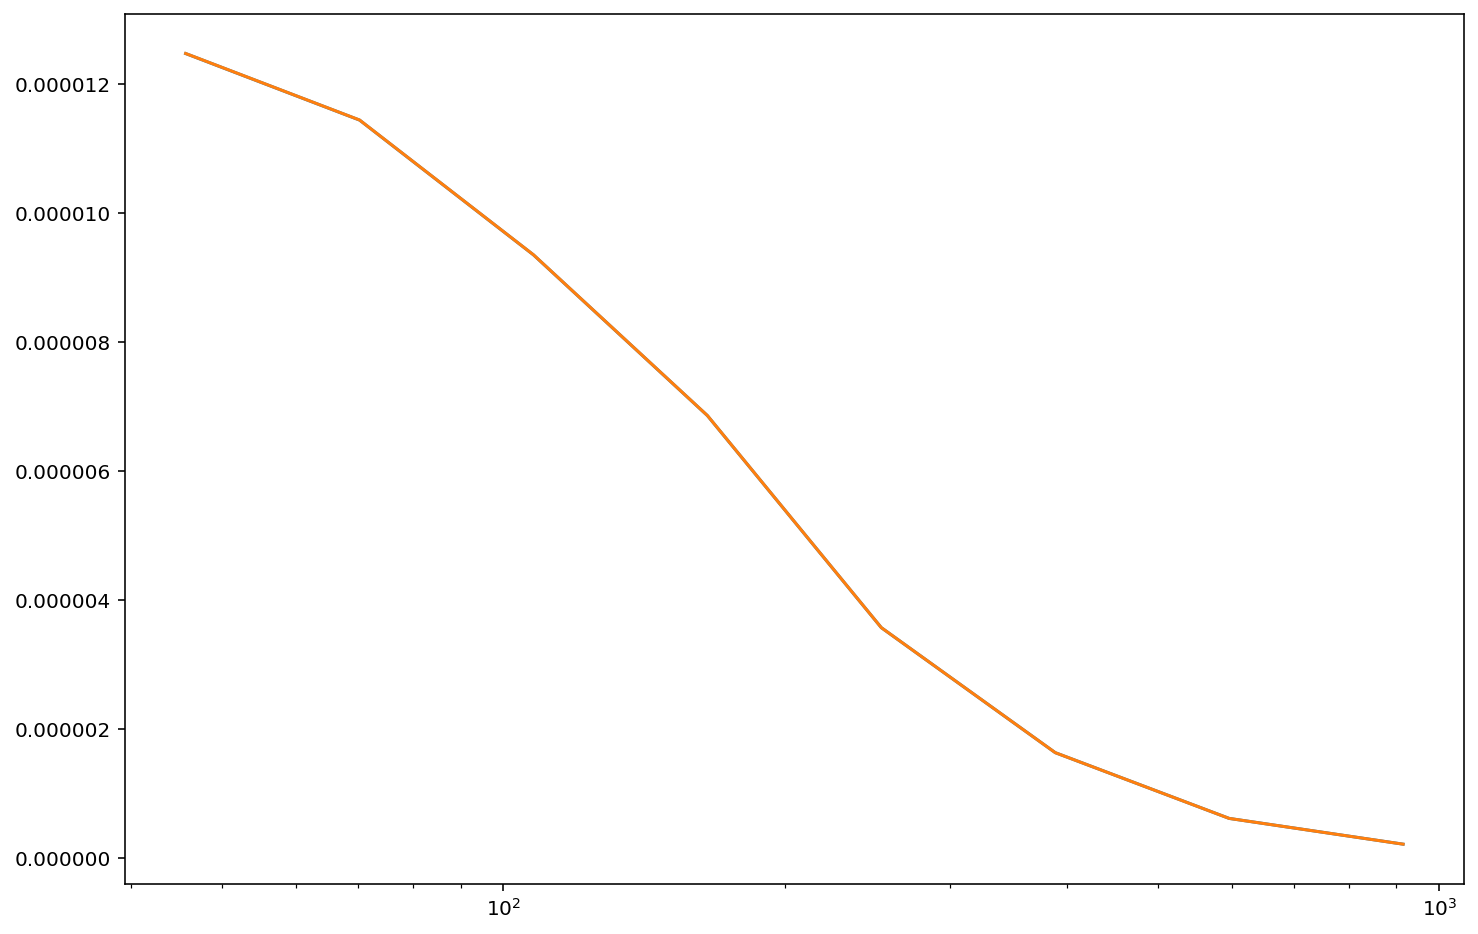

In [107]:
plt.plot(ells, w_from_prime)
plt.plot(ells, result_0.ws[-1])
plt.xscale('log')

In [115]:
check = np.einsum('ij, ...j -> ...i', (SA.P+np.sqrt(2)*SA.Q), Vec2)
check = np.einsum('...i, i -> ...', check, SA.E)
print(check.shape)
SA.integrate(check, ells)

(8,)


1.0000000000000007

In [116]:
a1 = np.sqrt(Vec2[:, 0]/w_from_prime)
a2 = np.sqrt(Vec2[:, 1]/(w_from_prime))
a3 = np.sqrt(Vec2[:, 2]/(w_from_prime))
a1+a2+a3

array([1.        , 1.        , 1.00022857, 1.00122428, 1.00259401,
       1.01161473, 1.0253882 , 1.0249023 ])

In [117]:
Vec2[:, 0]*Vec2[:, 1]*2/Vec2[:, 5]**2

array([0.99999997, 1.00000012, 1.00000025, 0.99999999, 1.        ,
       1.        , 1.        , 1.        ])

In [118]:
wLcalculated = Vec2[:, 0:3].sum(axis = 1)+np.sqrt(2)*Vec2[:, 3:6].sum(axis = 1)
wLcalculated

array([1.24707153e-05, 1.14393266e-05, 9.34973459e-06, 6.85824518e-06,
       3.57094755e-06, 1.63340628e-06, 6.14277375e-07, 2.15018761e-07])

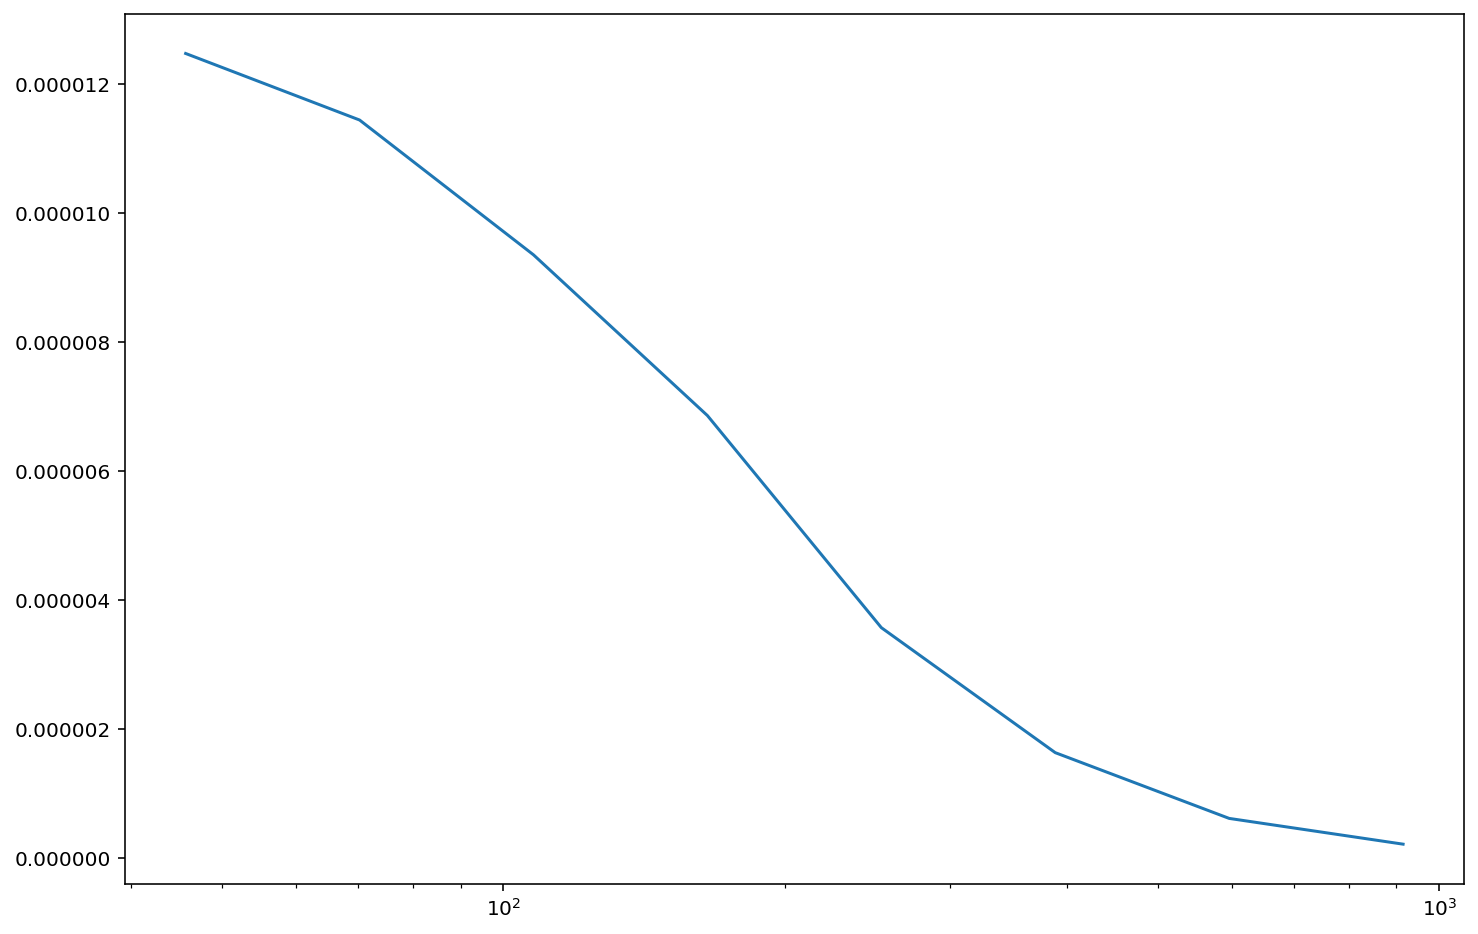

In [120]:
plt.plot(ells, wLcalculated)
plt.xscale('log')

In [121]:
a2 = Vec2[:, 5]**2/Vec2[:, 0]/wLcalculated/2
a1 = Vec2[:, 5]**2/Vec2[:, 1]/wLcalculated/2
a3 = Vec2[:, 3]**2/Vec2[:, 1]/wLcalculated/2

In [122]:
# Aprime = w*A

In [124]:
A1prime = np.sqrt(Vec2[..., 0]) 
A1prime

array([5.01039430e-05, 4.76249425e-05, 4.45207021e-05, 4.19964743e-05,
       3.22274076e-05, 1.65948732e-05, 7.22906545e-06, 2.78400456e-06])

In [125]:
A2prime = np.sqrt(Vec2[..., 1])
A2prime

array([1.50022754e-06, 7.99161626e-07, 3.49451971e-07, 1.60308735e-06,
       2.45094412e-06, 7.42208782e-06, 9.94911024e-06, 5.77361226e-06])

In [126]:
A3prime = np.sqrt(Vec2[..., 2])
A3prime

array([0.00347979, 0.00333378, 0.00301356, 0.00257843, 0.00185992,
       0.00126888, 0.00078648, 0.00046669])

In [129]:
invsigma2 = np.nan_to_num(theta[0, 0, 0, 0, :]**-1)
invsigma2[1] = 0.
factor = SA.integrate(invsigma2, ells)
invvarweights_hu_ok = invsigma2*factor**-1

In [130]:
a1code, a2code, a3code, w = result_0.ws

In [131]:
w

array([1.24717948e-05, 1.14403312e-05, 9.35054997e-06, 6.85883908e-06,
       3.57124330e-06, 1.63346999e-06, 6.14161943e-07, 2.14959633e-07])

In [132]:
SA.integrate(w, ells)

1.0

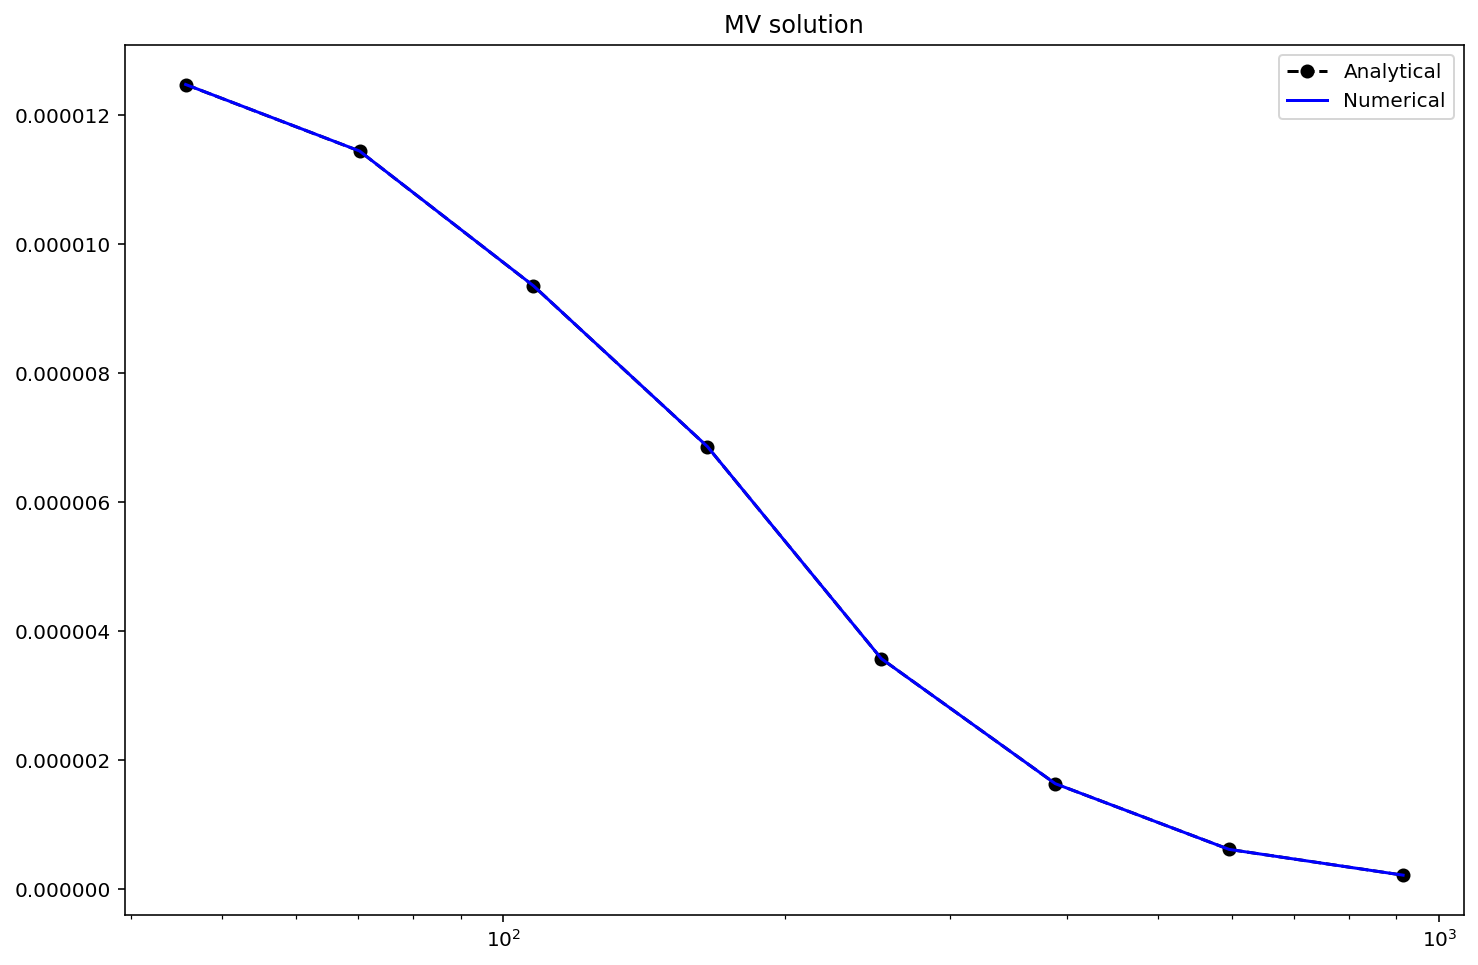

In [133]:
plt.title('MV solution')
plt.plot(ells, wLcalculated, ls = '--', label = 'Analytical', color = 'black', marker = 'o')
plt.plot(ells, w, label = 'Numerical', color = 'blue')
plt.xscale('log')
plt.legend()

In [134]:
a1 = np.nan_to_num(A1prime/np.sqrt(w_from_prime))
a2 = np.nan_to_num(A2prime/np.sqrt(w_from_prime))
a3 = np.nan_to_num(A3prime/np.sqrt(w_from_prime))
a1+a2+a3

array([1.        , 1.        , 1.00022857, 1.00122428, 1.00259401,
       1.01161473, 1.0253882 , 1.0249023 ])

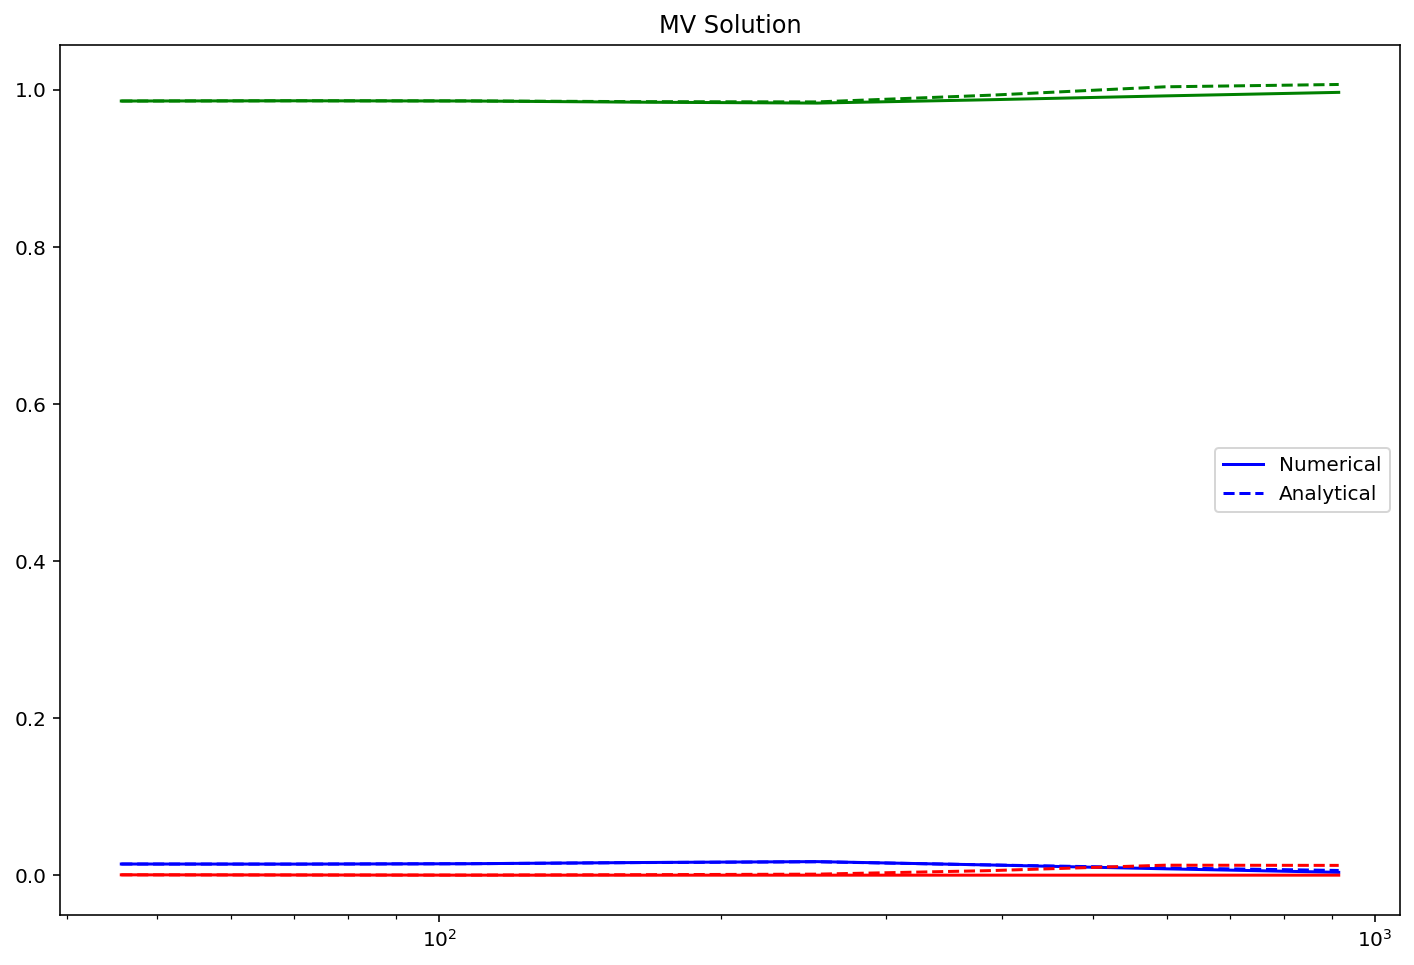

In [135]:
plt.title('MV Solution')

plt.plot(ells, a1code, color = 'blue', label = 'Numerical')
plt.plot(ells, a2code, color = 'red')
plt.plot(ells, a3code, color = 'green')

plt.plot(ells, a1, ls = '--', color = 'blue', label = 'Analytical')
plt.plot(ells, a2, ls = '--', color = 'red')
plt.plot(ells, a3, ls = '--', color = 'green')
plt.xscale('log')
plt.legend()